In [1]:
import os
import pandas as pd
import scanpy as sc
import numpy as np
import jax.tree_util as jtu
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import issparse
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict
#from utils import calc_zscores, plot_heatmaps_by_knockout_ordered, filter_deg_optimized, calculate_similarities
from functools import partial

cmap = sns.color_palette("coolwarm", as_cmap=True)
cell_line_order = ['HAP1', 'K562', 'A549', 'HT29', 'MCF7','Mean', 'BXPC3', 'BXPC3 (predicted)']

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/figures/satija/downtream_heatmaps"

In [3]:
def calc_zscores_limited_nr_cells(sample1, sample2, limit_sample_1, limit_sample_2):
    if issparse(sample1):
        sample1 = sample1.toarray()
    if issparse(sample2):
        sample2 = sample2.toarray()

    # limit_sample_1 = np.min(limit_sample_1, sample1.shape[0])
    # limit_sample_2 = np.min(limit_sample_2, sample2.shape[0])
    sample1 = sample1[limit_sample_1,:]
    sample2 = sample2[limit_sample_2,:]

    mean1 = sample1.mean(axis=0)
    std1 = sample1.std(axis=0)
    mean2 = sample2.mean(axis=0)
    std2 = sample2.std(axis=0)
    
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    se = np.sqrt((std1**2 / n1) + (std2**2 / n2))
    
    z_scores = (mean1 - mean2) / se
    return z_scores


def calc_zscores(sample1, sample2):
    try:
        sample1 = sample1.toarray()
    except:
        pass
    try:
        sample2 = sample2.toarray()
    except:
        pass
    try:
        mean1 = sample1.mean(axis=0)
        std1 = sample1.std(axis=0)
        mean2 = sample2.mean(axis=0)
        std2 = sample2.std(axis=0)
        n1 = sample1.shape[0]
        n2 = sample2.shape[0]
        se = np.sqrt((std1**2 / n1) + (std2**2 / n2))
        z_scores = (mean1 - mean2) / se
    except Exception as e:
        print(e)
    return z_scores

In [4]:
predictions_path = '/lustre/groups/ml01/workspace/alessandro.palma/ot_pert/out/results_metrics/generated_data/sweep_cell_line_pathway/adata_ood_split_BXPC3_IFNG.h5ad'
train_path = '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_pathway_cell_type/BXPC3_IFNG/adata_train_BXPC3_IFNG.h5ad'
test_path = '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_pathway_cell_type/BXPC3_IFNG/adata_test_BXPC3_IFNG.h5ad'
ood_path = '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_pathway_cell_type_full_source/BXPC3_IFNG/adata_ood_BXPC3_IFNG.h5ad'

In [5]:
predictions = sc.read_h5ad(predictions_path)
train = sc.read_h5ad(train_path)
test = sc.read_h5ad(test_path)
ood = sc.read_h5ad(ood_path)

# generate dicts for jtu tree_map
ood_target = ood[ood.obs['gene'] != 'NT', :]
ood_source = ood[ood.obs['gene'] == 'NT', :]
ood_target_dict = {c: ood_target[ood_target.obs['condition'] == c, :].X for c in ood_target.obs['condition'].unique()}
ood_source_dict = {c: ood_source[ood_source.obs['pathway'] == c.split('_')[1], :].X for c in ood_target.obs['condition'].unique()}
ood_prediction = {c: predictions[predictions.obs['condition'] == c].layers['X_recon_pred'] for c in predictions.obs['condition'].unique()}

train = ad.concat([train, test])
train_target = train[train.obs['gene'] != 'NT', :]
train_source = train[train.obs['gene'] == 'NT', :]
train_target_dict = {c: train_target[train_target.obs['condition'] == c, :].X for c in train_target.obs['condition'].unique()}
train_source_dict = {c: train_source[train_source.obs['pathway'] == c.split('_')[1], :].X for c in train_target.obs['condition'].unique()}

In [6]:
perturbation_programs = pd.read_csv('/lustre/groups/ml01/workspace/ot_perturbation/data/satija2/table3_programs.csv')


In [7]:
present_in_BXPC3 = perturbation_programs.query('cellline == "BXPC3" and pathway == "IFNG"')[['pathway', 'program', 'gene', 'perturbation']].drop_duplicates()
valid_combinations = set(zip(present_in_BXPC3['gene'], present_in_BXPC3['perturbation'], present_in_BXPC3['pathway'], present_in_BXPC3['program']))

filtered_df = perturbation_programs[
    perturbation_programs[['gene', 'perturbation', 'pathway', 'program']].apply(tuple, axis=1).isin(valid_combinations)
]

cell_line_counts = (
    filtered_df.groupby(['gene', 'pathway', 'perturbation', 'program'])['cellline']
    .nunique()
    .reset_index(name='cellline_count')
)

valid_combinations = cell_line_counts[cell_line_counts['cellline_count'] >= 6] # TODO: should we choose another threshold?

df_present_in_all_ct = filtered_df.merge(valid_combinations[['gene', 'pathway', 'perturbation', 'program']], 
                                on=['gene', 'pathway', 'perturbation', 'program'], 
                                how='inner')

In [8]:
ood_zscores = jtu.tree_map(calc_zscores, ood_target_dict, ood_source_dict)
prediction_zscores = jtu.tree_map(calc_zscores, ood_prediction, ood_source_dict)
train_zscores = jtu.tree_map(calc_zscores, train_target_dict, train_source_dict)

/tmp/ipykernel_2529708/1423005450.py:42: RuntimeWarning: invalid value encountered in divide
  z_scores = (mean1 - mean2) / se


In [9]:
df_train = []
for key, value in train_zscores.items():
    df_train.append(pd.DataFrame({
        'predicted': False,
        'cell_line': key.split('_')[0],
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(train.var_names),
        'zscore': value
    }))
df_train = pd.concat(df_train)

df_ood = []
for key, value in ood_zscores.items():
    df_ood.append(pd.DataFrame({
        'predicted': False,
        'cell_line': key.split('_')[0],
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(ood.var_names),
        'zscore': value
    }))
df_ood = pd.concat(df_ood)

df_prediction = []
for key, value in prediction_zscores.items():
    df_prediction.append(pd.DataFrame({
        'predicted': True,
        'cell_line': key.split('_')[0] + ' (predicted)',
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(ood.var_names),
        'zscore': value
    }))
df_predicted = pd.concat(df_prediction)
df_predicted_filtered = df_predicted[df_predicted['zscore'].notna()]

df_ground_truth = pd.concat([df_train, df_ood])
df_ground_truth_filtered = df_ground_truth[df_ground_truth['zscore'].notna()]

df_zscores = pd.concat([df_ground_truth, df_predicted])

In [10]:
df_ground_truth["cell_line"].value_counts()

cell_line
BXPC3    1322400
MCF7     1115775
HT29      801705
HAP1      562020
K562      545490
A549      429780
Name: count, dtype: int64

In [11]:
perturbation_programs["cellline"].value_counts()

cellline
BXPC3    23963
HT29     21457
K562     21386
A549     20609
MCF7     15062
HAP1      8746
Name: count, dtype: int64

In [12]:
present_in_BXPC3 = perturbation_programs.query('cellline == "BXPC3" and pathway == "IFNG"')[['pathway', 'program', 'gene', 'perturbation']].drop_duplicates()
valid_combinations = set(zip(present_in_BXPC3['gene'], present_in_BXPC3['perturbation'], present_in_BXPC3['pathway'], present_in_BXPC3['program']))

filtered_df = perturbation_programs[
    perturbation_programs[['gene', 'perturbation', 'pathway', 'program']].apply(tuple, axis=1).isin(valid_combinations)
]

cell_line_counts = (
    filtered_df.groupby(['gene', 'pathway', 'perturbation', 'program'])['cellline']
    .nunique()
    .reset_index(name='cellline_count')
)

valid_combinations = cell_line_counts[cell_line_counts['cellline_count'] >= 6] # TODO: should we choose another threshold?

df_present_in_all_ct = filtered_df.merge(valid_combinations[['gene', 'pathway', 'perturbation', 'program']], 
                                on=['gene', 'pathway', 'perturbation', 'program'], 
                                how='inner')
df_present_in_all_ct = df_present_in_all_ct.drop(columns=['Unnamed: 0'])

In [13]:
df_present_in_all_ct['program'].value_counts()

program
IFNG_program1_up      9000
IFNG_program1_down    9000
Name: count, dtype: int64

# Program 1

In [14]:
IFNG_program1 = df_present_in_all_ct.query('program =="IFNG_program1_up" or program == "IFNG_program1_down"')
IFNG_program1 = IFNG_program1.rename(columns={'perturbation': 'knockout'}).drop(columns=['cellline'])
df_selected = df_zscores.merge(IFNG_program1, on=['pathway', 'gene', 'knockout'], how='inner').drop_duplicates()

In [15]:
df_selected_train = df_selected[~df_selected['cell_line'].str.contains('BXPC3')]
df_selected_train

,predicted,cell_line,pathway,knockout,gene,zscore,program
0,False,A549,IFNG,IFNGR1,ABCC3,13.510861,IFNG_program1_up
6,False,A549,IFNG,IFNGR1,ABLIM1,-0.555422,IFNG_program1_up
12,False,A549,IFNG,IFNGR1,ABLIM3,-1.288935,IFNG_program1_up
18,False,A549,IFNG,IFNGR1,AC004784.1,2.921746,IFNG_program1_up
24,False,A549,IFNG,IFNGR1,AC005515.1,-23.818016,IFNG_program1_down
...,...,...,...,...,...,...,...
30330,False,MCF7,IFNG,JAK2,XACT,-20.574600,IFNG_program1_up
30336,False,MCF7,IFNG,JAK2,XRN1,-16.540094,IFNG_program1_down
30342,False,MCF7,IFNG,JAK2,ZC3HAV1,-31.493265,IFNG_program1_down
30348,False,MCF7,IFNG,JAK2,ZNF704,20.258299,IFNG_program1_up


In [16]:
df_selected_train["cell_line"].value_counts()

cell_line
A549    1100
HT29    1100
K562    1100
HAP1     880
MCF7     880
Name: count, dtype: int64

In [17]:
df_mean_zscore = df_selected_train.groupby(['knockout', 'gene', 'program'])['zscore'].mean().reset_index()
df_mean_zscore['cell_line'] = 'Mean'
df_mean_zscore['predicted'] = True
df_mean_zscore['pathway'] = 'IFNG'
df_mean_zscore

,knockout,gene,program,zscore,cell_line,predicted,pathway
0,IFNGR1,ABCC3,IFNG_program1_up,-10.294456,Mean,True,IFNG
1,IFNGR1,ABLIM1,IFNG_program1_up,-3.805677,Mean,True,IFNG
2,IFNGR1,ABLIM3,IFNG_program1_up,0.075091,Mean,True,IFNG
3,IFNGR1,AC004784.1,IFNG_program1_up,0.458993,Mean,True,IFNG
4,IFNGR1,AC005515.1,IFNG_program1_down,-31.512077,Mean,True,IFNG
...,...,...,...,...,...,...,...
1095,STAT1,XACT,IFNG_program1_up,-3.965842,Mean,True,IFNG
1096,STAT1,XRN1,IFNG_program1_down,-13.558362,Mean,True,IFNG
1097,STAT1,ZC3HAV1,IFNG_program1_down,-18.677998,Mean,True,IFNG
1098,STAT1,ZNF704,IFNG_program1_up,-13.331358,Mean,True,IFNG


In [18]:
df_selected = pd.concat([df_mean_zscore, df_selected])


In [19]:
df_selected.head()

,knockout,gene,program,zscore,cell_line,predicted,pathway
0,IFNGR1,ABCC3,IFNG_program1_up,-10.294456,Mean,True,IFNG
1,IFNGR1,ABLIM1,IFNG_program1_up,-3.805677,Mean,True,IFNG
2,IFNGR1,ABLIM3,IFNG_program1_up,0.075091,Mean,True,IFNG
3,IFNGR1,AC004784.1,IFNG_program1_up,0.458993,Mean,True,IFNG
4,IFNGR1,AC005515.1,IFNG_program1_down,-31.512077,Mean,True,IFNG


In [20]:
cell_line_order = ["A549", "HAP1", "HT29", "K562", "MCF7", "Mean", "BXPC3 (predicted)", "BXPC3"]
vmin=-15
vmax=15
ylim_min=-0.2
ylim_max=1.1

cell_line_cols = {"A549": "#EF9690", "HAP1": "#4DB377", "HT29": "#65BFC6", "K562": "#A6B4DF", "MCF7": "#D590C0", "Mean": "#566573", "BXPC3 (predicted)": "#B12F8C", "BXPC3": "#BEBE65"}

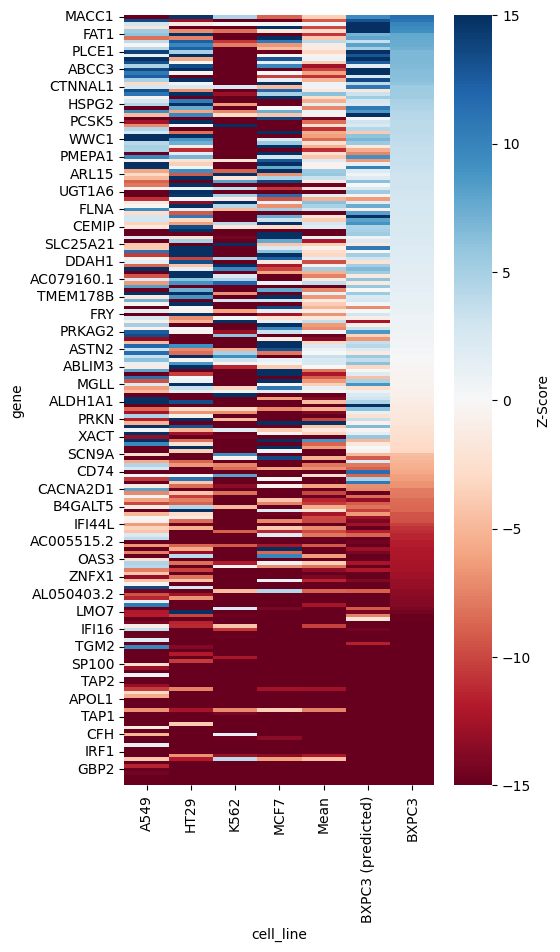

In [21]:
df_ifngr1 = df_selected[df_selected["knockout"]=="IFNGR1"]
gene_order = list(df_ifngr1[df_ifngr1["cell_line"]=="BXPC3"].sort_values("zscore", ascending=False)["gene"])

df_ifngr1= df_ifngr1[["zscore","cell_line", "gene"]].pivot(columns="cell_line", index="gene", values="zscore")
df_ifngr1 = df_ifngr1.loc[gene_order]
df_ifngr1 = df_ifngr1.loc[:, [el for el in cell_line_order if el in df_ifngr1.columns]]


fig, ax = plt.subplots(figsize=(5, 10))
fig = sns.heatmap(
    df_ifngr1,
    ax=ax,
    cmap="RdBu",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={'label': 'Z-Score'}
)

fig.figure.savefig(os.path.join(output_dir, "ifngr1.pdf"))

/tmp/ipykernel_2529708/2307758712.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.barplot(
/tmp/ipykernel_2529708/2307758712.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


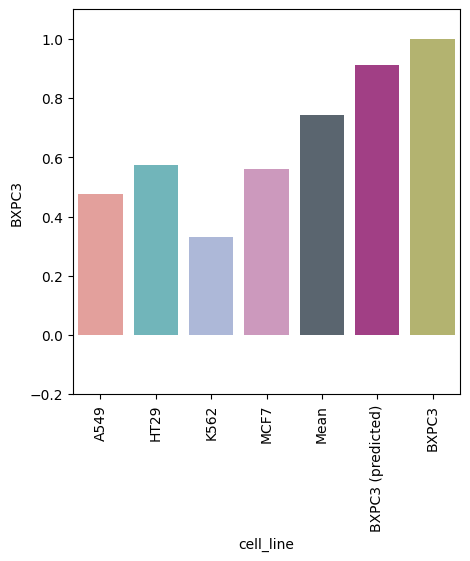

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sns.barplot(
    df_ifngr1.corr(method="pearson").loc["BXPC3"],
    ax=ax,
    palette=cell_line_cols,
)

ax.set_ylim(ylim_min, ylim_max)  # Equivalent to vmin & vmax in heatmaps

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.figure.savefig(os.path.join(output_dir, "ifngr1_corr_true.pdf"))

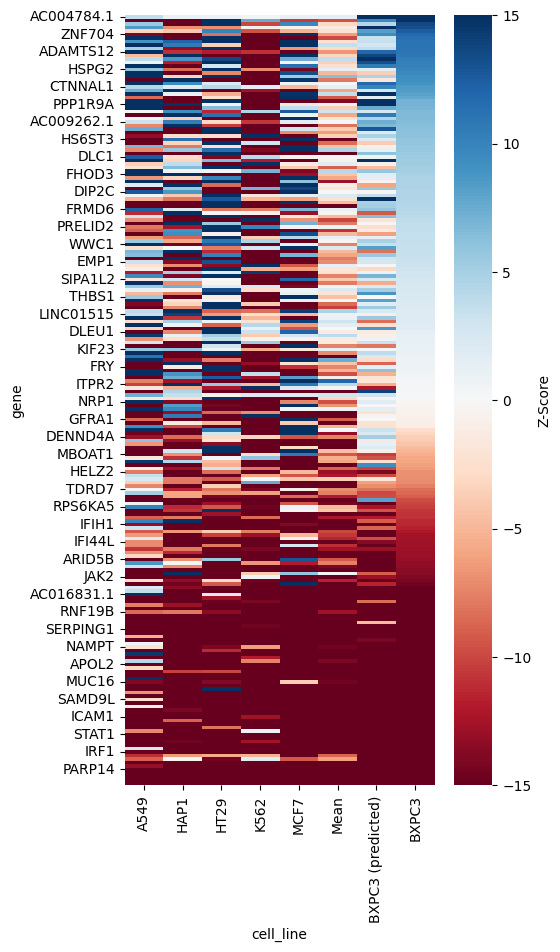

In [23]:
df_ifngr2 = df_selected[df_selected["knockout"]=="IFNGR2"]
gene_order = list(df_ifngr2[df_ifngr2["cell_line"]=="BXPC3"].sort_values("zscore", ascending=False)["gene"])

df_ifngr2= df_ifngr2[["zscore","cell_line", "gene"]].pivot(columns="cell_line", index="gene", values="zscore")
df_ifngr2 = df_ifngr2.loc[gene_order]
df_ifngr2 = df_ifngr2.loc[:, [el for el in cell_line_order if el in df_ifngr2.columns]]


fig, ax = plt.subplots(figsize=(5, 10))
fig = sns.heatmap(
    df_ifngr2,
    ax=ax,
    cmap="RdBu",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={'label': 'Z-Score'}
)

fig.figure.savefig(os.path.join(output_dir, "ifngr2.pdf"))

/tmp/ipykernel_2529708/1950328530.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.barplot(
/tmp/ipykernel_2529708/1950328530.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


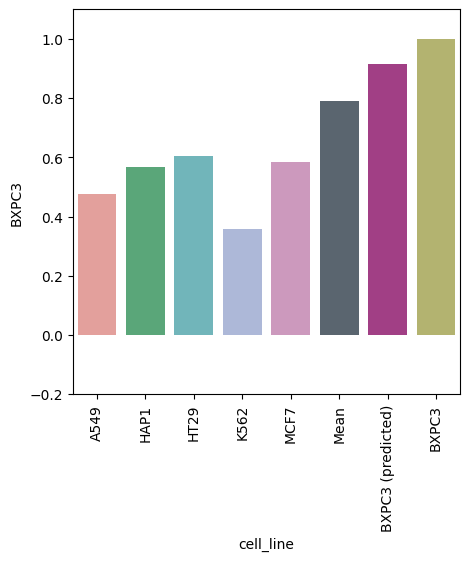

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sns.barplot(
    df_ifngr2.corr(method="pearson").loc["BXPC3"],
    ax=ax,
    palette=cell_line_cols,
)

ax.set_ylim(ylim_min, ylim_max)  # Equivalent to vmin & vmax in heatmaps

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.figure.savefig(os.path.join(output_dir, "ifngr2_corr_true.pdf"))

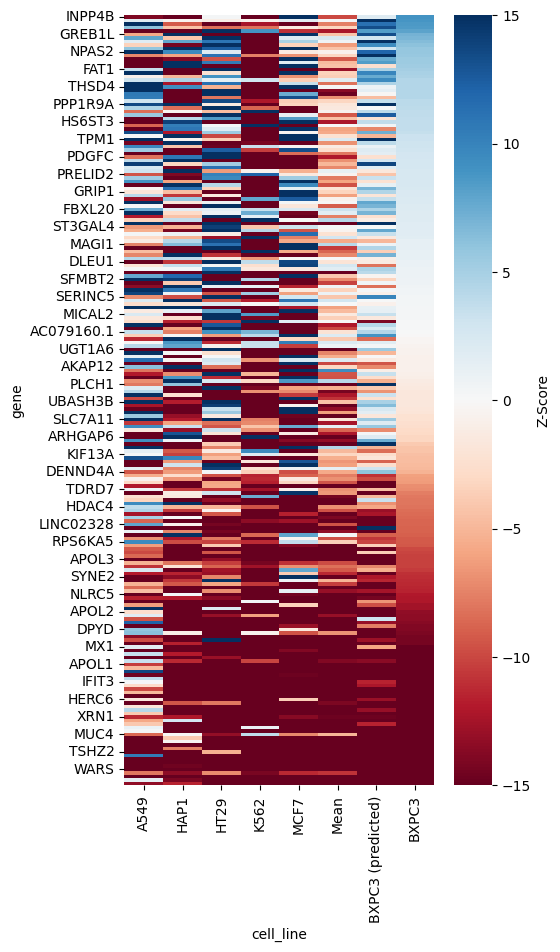

In [25]:
df_jak1 = df_selected[df_selected["knockout"]=="JAK1"]
gene_order = list(df_jak1[df_jak1["cell_line"]=="BXPC3"].sort_values("zscore", ascending=False)["gene"])

df_jak1= df_jak1[["zscore","cell_line", "gene"]].pivot(columns="cell_line", index="gene", values="zscore")
df_jak1 = df_jak1.loc[gene_order]
df_jak1 = df_jak1.loc[:,[el for el in cell_line_order if el in df_jak1.columns]]


fig, ax = plt.subplots(figsize=(5, 10))
fig = sns.heatmap(
    df_jak1,
    ax=ax,
    cmap="RdBu",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={'label': 'Z-Score'}
)

fig.figure.savefig(os.path.join(output_dir, "jak1.pdf"))

/tmp/ipykernel_2529708/2685206630.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.barplot(
/tmp/ipykernel_2529708/2685206630.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


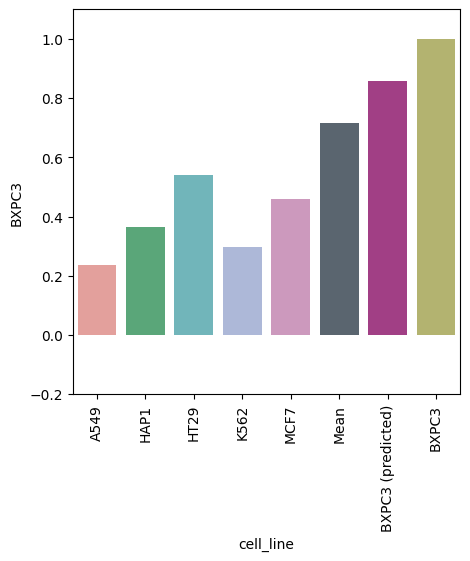

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sns.barplot(
    df_jak1.corr(method="pearson").loc["BXPC3"],
    ax=ax,
    palette=cell_line_cols,
)

ax.set_ylim(ylim_min, ylim_max)  # Equivalent to vmin & vmax in heatmaps

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.figure.savefig(os.path.join(output_dir, "jak1_corr_true.pdf"))

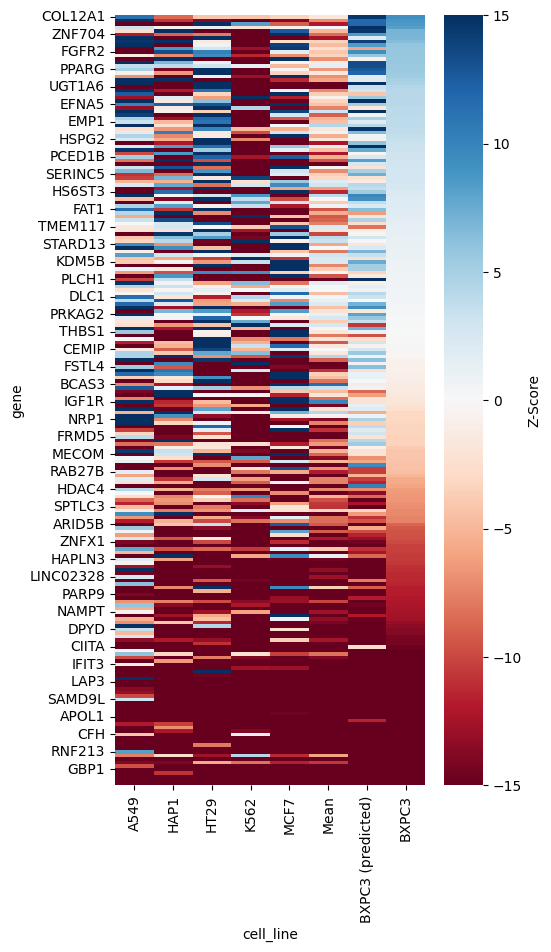

In [27]:
df_jak2 = df_selected[df_selected["knockout"]=="JAK2"]
gene_order = list(df_jak2[df_jak2["cell_line"]=="BXPC3"].sort_values("zscore", ascending=False)["gene"])

df_jak2= df_jak2[["zscore","cell_line", "gene"]].pivot(columns="cell_line", index="gene", values="zscore")
df_jak2 = df_jak2.loc[gene_order]
df_jak2 = df_jak2.loc[:, [el for el in cell_line_order if el in df_jak2.columns]]


fig, ax = plt.subplots(figsize=(5, 10))
fig = sns.heatmap(
    df_jak2,
    ax=ax,
    cmap="RdBu",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={'label': 'Z-Score'}
)

fig.figure.savefig(os.path.join(output_dir, "jak2.pdf"))

/tmp/ipykernel_2529708/1730299964.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.barplot(
/tmp/ipykernel_2529708/1730299964.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


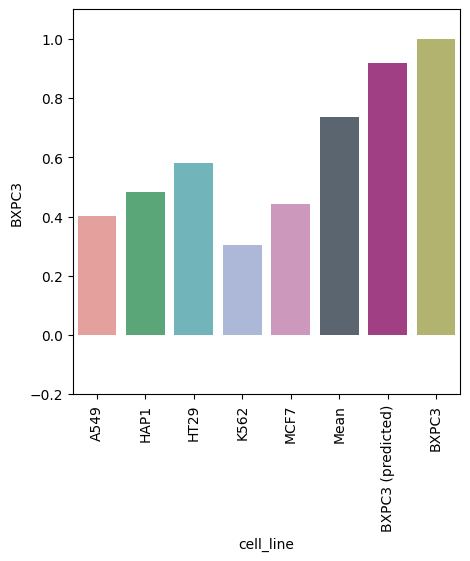

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sns.barplot(
    df_jak2.corr(method="pearson").loc["BXPC3"],
    ax=ax,
    palette=cell_line_cols,
)

ax.set_ylim(ylim_min, ylim_max)  # Equivalent to vmin & vmax in heatmaps

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.figure.savefig(os.path.join(output_dir, "jak2_corr_true.pdf"))

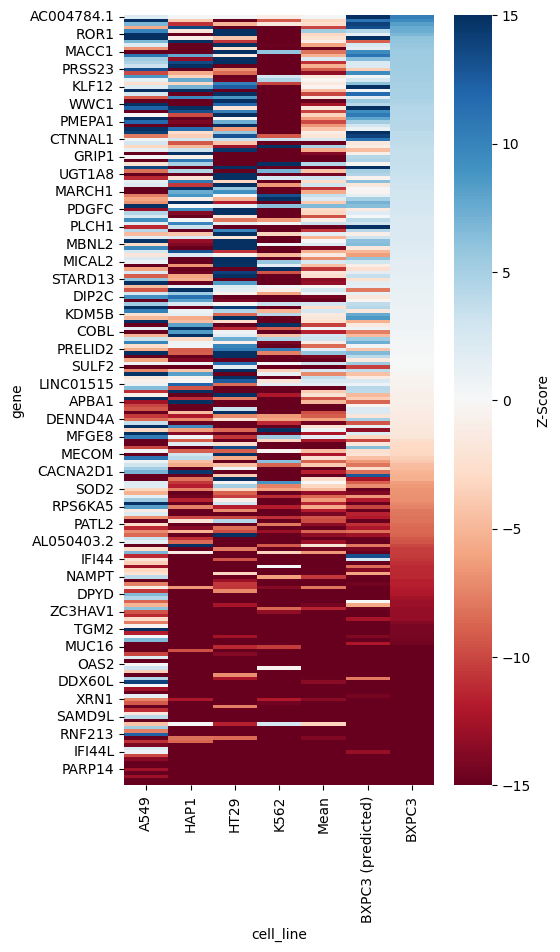

In [29]:
df_stat1 = df_selected[df_selected["knockout"]=="STAT1"]
gene_order = list(df_stat1[df_stat1["cell_line"]=="BXPC3"].sort_values("zscore", ascending=False)["gene"])

df_stat1= df_stat1[["zscore","cell_line", "gene"]].pivot(columns="cell_line", index="gene", values="zscore")
df_stat1 = df_stat1.loc[gene_order]
df_stat1 = df_stat1.loc[:, [el for el in cell_line_order if el in df_stat1.columns]]


fig, ax = plt.subplots(figsize=(5, 10))
fig = sns.heatmap(
    df_stat1,
    ax=ax,
    cmap="RdBu",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={'label': 'Z-Score'}
)

fig.figure.savefig(os.path.join(output_dir, "stat1.pdf"))

/tmp/ipykernel_2529708/3855293971.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.barplot(
/tmp/ipykernel_2529708/3855293971.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


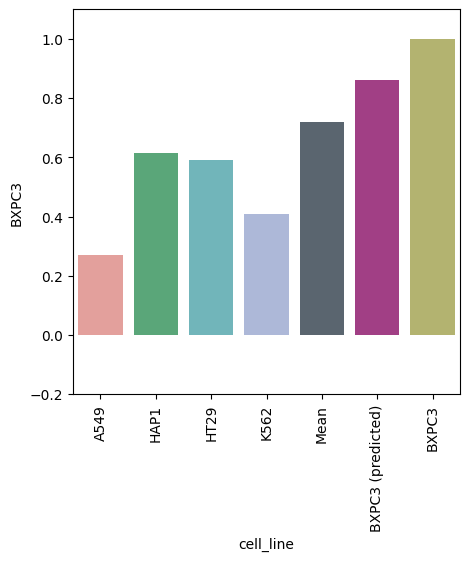

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sns.barplot(
    df_stat1.corr(method="pearson").loc["BXPC3"],
    ax=ax,
    palette=cell_line_cols,
)

ax.set_ylim(ylim_min, ylim_max)  # Equivalent to vmin & vmax in heatmaps

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.figure.savefig(os.path.join(output_dir, "stat1_corr_true.pdf"))

In [31]:
df_mean = pd.concat((df_stat1.corr(method="pearson").loc[["Mean"]], 
           df_jak1.corr(method="pearson").loc[["Mean"]],
           df_jak2.corr(method="pearson").loc[["Mean"]],
           df_ifngr1.corr(method="pearson").loc[["Mean"]],
           df_ifngr2.corr(method="pearson").loc[["Mean"]]))

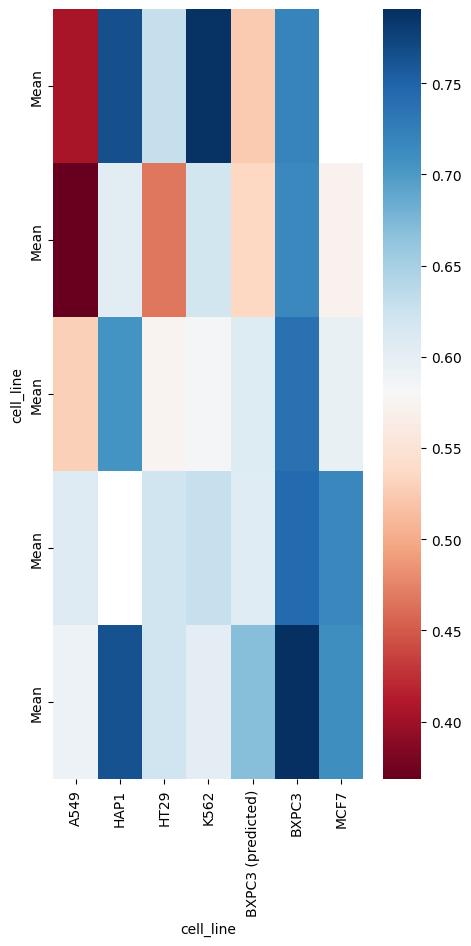

In [32]:


fig, ax = plt.subplots(figsize=(5, 10))
fig = sns.heatmap(
    data=df_mean.drop(columns=["Mean"]),
    ax=ax,
    cmap="RdBu",
)

fig.figure.savefig(os.path.join(output_dir, "correlations_with_mean.pdf"))

# Program 2

In [33]:
program2 = perturbation_programs.query('program =="IFNG_program2_up" or program == "IFNG_program2_down"')[['pathway', 'program', 'gene', 'perturbation']].drop_duplicates()
valid_combinations = set(zip(program2['gene'], program2['perturbation'], program2['pathway'], program2['program']))

program2_df = perturbation_programs[
    perturbation_programs[['gene', 'perturbation', 'pathway', 'program']].apply(tuple, axis=1).isin(valid_combinations)
]

In [34]:
program2_df = program2_df.rename(columns={'perturbation': 'knockout'}).drop(columns=['cellline', 'Unnamed: 0', 'program'])
df_selected = df_zscores.merge(program2_df, on=['pathway', 'gene', 'knockout'], how='inner').drop_duplicates()

In [35]:
df_selected['cell_line_orig'] = df_selected['cell_line']
df_selected['cell_line'] = df_selected['cell_line'] + ' (' + df_selected['knockout'] + ')'
df_selected['knockout'] = 'IFNG program 2'


In [36]:
df_selected_train = df_selected[~df_selected['cell_line'].str.contains('BXPC3')]

In [37]:
df_mean_zscore = df_selected_train.groupby(['knockout', 'gene'])['zscore'].mean().reset_index()
df_mean_zscore['cell_line'] = 'Mean (IRF1)'
df_mean_zscore['cell_line_orig'] = 'Mean'
df_mean_zscore['predicted'] = True
df_mean_zscore['pathway'] = 'IFNG'
df_mean_zscore

,knockout,gene,zscore,cell_line,cell_line_orig,predicted,pathway
0,IFNG program 2,ABCC3,-14.812412,Mean (IRF1),Mean,True,IFNG
1,IFNG program 2,AC005515.1,-17.628111,Mean (IRF1),Mean,True,IFNG
2,IFNG program 2,AC005515.2,-15.640966,Mean (IRF1),Mean,True,IFNG
3,IFNG program 2,AC016831.1,-13.228501,Mean (IRF1),Mean,True,IFNG
4,IFNG program 2,AC099520.1,-14.414729,Mean (IRF1),Mean,True,IFNG
...,...,...,...,...,...,...,...
159,IFNG program 2,WARS,-7.388966,Mean (IRF1),Mean,True,IFNG
160,IFNG program 2,XRN1,-4.964907,Mean (IRF1),Mean,True,IFNG
161,IFNG program 2,ZC3HAV1,-8.045498,Mean (IRF1),Mean,True,IFNG
162,IFNG program 2,ZFP36L1,-3.820950,Mean (IRF1),Mean,True,IFNG


In [38]:
df_selected = pd.concat([df_selected, df_mean_zscore])
df_selected = df_selected[~df_selected["cell_line"].isin(('BXPC3 (IRF2)', 'BXPC3 (predicted) (IRF2)'))]

In [39]:
df_selected

,predicted,cell_line,pathway,knockout,gene,zscore,cell_line_orig
0,False,A549 (IRF1),IFNG,IFNG program 2,ABCC3,15.182554,A549
3,False,A549 (IRF1),IFNG,IFNG program 2,AC005515.1,3.822694,A549
6,False,A549 (IRF1),IFNG,IFNG program 2,AC005515.2,4.145197,A549
9,False,A549 (IRF1),IFNG,IFNG program 2,AC016831.1,22.745880,A549
12,False,A549 (IRF1),IFNG,IFNG program 2,AC099520.1,-10.305631,A549
...,...,...,...,...,...,...,...
159,True,Mean (IRF1),IFNG,IFNG program 2,WARS,-7.388966,Mean
160,True,Mean (IRF1),IFNG,IFNG program 2,XRN1,-4.964907,Mean
161,True,Mean (IRF1),IFNG,IFNG program 2,ZC3HAV1,-8.045498,Mean
162,True,Mean (IRF1),IFNG,IFNG program 2,ZFP36L1,-3.820950,Mean


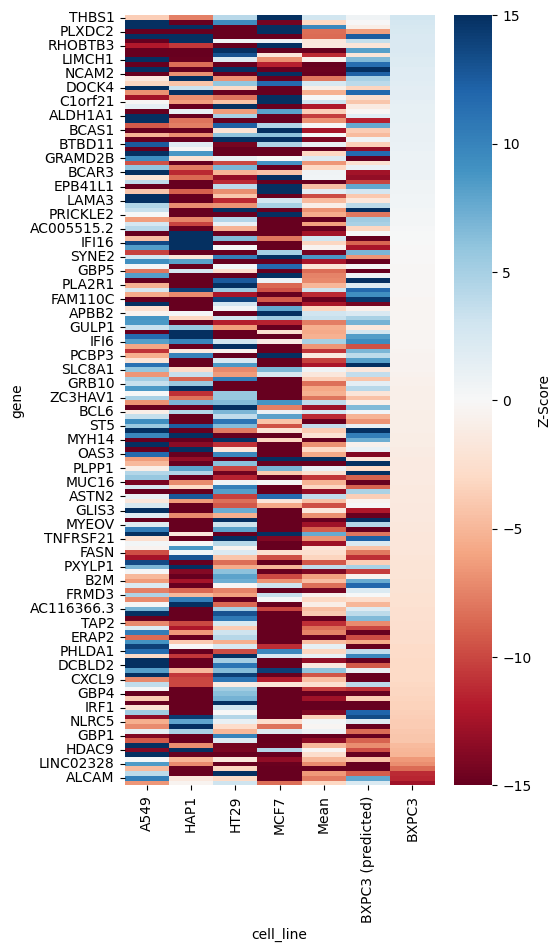

In [40]:
df_irf1 = df_selected[df_selected["knockout"]=='IFNG program 2']
gene_order = list(df_irf1[df_irf1["cell_line"]=="BXPC3 (IRF1)"].sort_values("zscore", ascending=False)["gene"])

df_irf1= df_irf1[["zscore","cell_line", "gene"]].pivot(columns="cell_line", index="gene", values="zscore")
df_irf1 = df_irf1.loc[gene_order]
df_irf1 = df_irf1.rename(columns={el: " ".join(el.split(" ")[:-1]) for el in df_irf1.columns})

df_irf1 = df_irf1.loc[:, [el for el in cell_line_order if el in df_irf1.columns]]

fig, ax = plt.subplots(figsize=(5, 10))
fig = sns.heatmap(
    df_irf1,
    ax=ax,
    cmap="RdBu",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={'label': 'Z-Score'}
)

fig.figure.savefig(os.path.join(output_dir, "irf1.pdf"))

/tmp/ipykernel_2529708/2969916891.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.barplot(
/tmp/ipykernel_2529708/2969916891.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


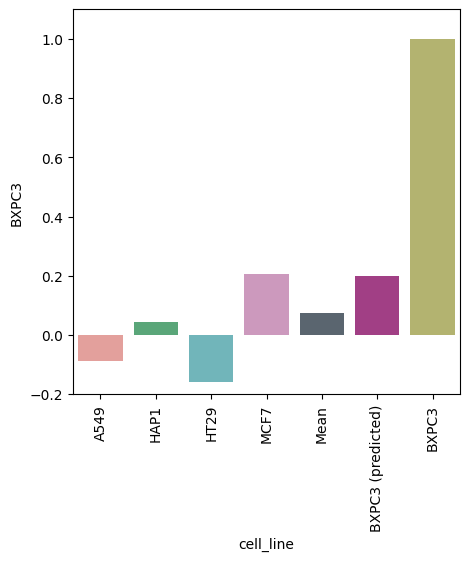

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sns.barplot(
    df_irf1.corr(method="pearson").loc["BXPC3"],
    ax=ax,
    palette=cell_line_cols,
)

ax.set_ylim(ylim_min, ylim_max)  # Equivalent to vmin & vmax in heatmaps

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.figure.savefig(os.path.join(output_dir, "irf1_corr_true.pdf"))